In [0]:
dbutils.fs.ls("/FileStore/tables/")


Out[1]: [FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2023/', name='clinicaltrial_2023/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2023-1.zip', name='clinicaltrial_2023-1.zip', size=57166668, modificationTime=1713832661000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2023.csv', name='clinicaltrial_2023.csv', size=292436366, modificationTime=1714269234000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2023.zip', name='clinicaltrial_2023.zip', size=57166668, modificationTime=1712589310000),
 FileInfo(path='dbfs:/FileStore/tables/pharma-1.zip', name='pharma-1.zip', size=109982, modificationTime=1713832611000),
 FileInfo(path='dbfs:/FileStore/tables/pharma.csv/', name='pharma.csv/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/pharma.zip', name='pharma.zip', size=109982, modificationTime=1712589332000),
 FileInfo(path='dbfs:/FileStore/tables/steam_200k-1.csv', name='steam_200k-1.csv', size=8059447, mod

In [0]:
dbutils.fs.cp("/FileStore/tables/clinicaltrial_2023.zip", "file:/tmp/")

Out[2]: True

In [0]:
%sh
ls /tmp/

Rserv
Rtmp1EUY0n
chauffeur-daemon-params
chauffeur-daemon.pid
chauffeur-env.sh
clinicaltrial_2023.zip
custom-spark.conf
driver-daemon-params
driver-daemon.pid
driver-env.sh
hsperfdata_root
python_lsp_logs
systemd-private-cd7aa280e67e429f85a0ae2cca21a4dc-apache2.service-MUpfHg
systemd-private-cd7aa280e67e429f85a0ae2cca21a4dc-ntp.service-yxq2vh
systemd-private-cd7aa280e67e429f85a0ae2cca21a4dc-systemd-logind.service-QqVD6g
systemd-private-cd7aa280e67e429f85a0ae2cca21a4dc-systemd-resolved.service-0WSoAf
tmp.jT9xtZh66L


In [0]:
%sh
unzip -d /tmp/ /tmp/clinicaltrial_2023.zip

Archive:  /tmp/clinicaltrial_2023.zip
  inflating: /tmp/clinicaltrial_2023.csv  


In [0]:
%sh
ls /tmp/clinicaltrial_2023.csv

/tmp/clinicaltrial_2023.csv


In [0]:
dbutils.fs.mv("file:/tmp/clinicaltrial_2023.csv", "/FileStore/tables/clinicaltrial_2023.csv", True)

Out[6]: True

In [0]:
dbutils.fs.ls("FileStore/tables/clinicaltrial_2023.csv/")

Out[7]: [FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2023.csv', name='clinicaltrial_2023.csv', size=292436366, modificationTime=1714515227000)]

In [0]:
dbutils.fs.head("FileStore/tables/clinicaltrial_2023.csv")

[Truncated to first 65536 bytes]
Out[8]: '"Id\tStudy Title\tAcronym\tStatus\tConditions\tInterventions\tSponsor\tCollaborators\tEnrollment\tFunder Type\tType\tStudy Design\tStart\tCompletion",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,\r\n"NCT03630471\tEffectiveness of a Problem-solving Intervention for Common Adolescent Mental Health Problems in India\tPRIDE\tCOMPLETED\tMental Health Issue (E.G.", Depression, Psychosis, Personality Disorder," Substance Abuse)\tBEHAVIORAL: PRIDE \'Step 1\' problem-solving intervention|BEHAVIORAL: Enhanced usual care\tSangath\tHarvard Medical School (HMS and HSDM)|London School of Hygiene and Tropical Medicine\t250.0\tOTHER\tINTERVENTIONAL\tAllocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE (INVESTIGATOR"," OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT\t2018-08-20\t2019-02-

In [0]:
janirdd = sc.textFile('/FileStore/tables/clinicaltrial_2023.csv')

In [0]:
from pyspark.sql import Row
cleanedRDD = janirdd.filter(lambda line: line.strip() != '')
fieldsRDD = cleanedRDD.map(lambda line: line.split('\t'))
cleanRDD = fieldsRDD.map(lambda row: [field.rstrip(',') for field in row])
cleanRDD = cleanRDD.map(lambda fields: [field.replace('"', '') for field in fields])


In [0]:
cleanedData = cleanRDD.collect()
for row in cleanedData:
    print(row)
def clean_row(row):
    if len(row) < 14:
        return row 
    row = row[:5] + [intervention for field in row[5].split('|') for intervention in field.split(':')] + row[6:]
    row = row[:7] + [collaborator.strip() for collaborator in row[7].split('|')] + row[8:] if row[7] else row[:7] + [] + row[8:]
    row = row[:11] + [design for field in row[11].split('|') for design in field.split(':')] + row[12:]

    return row

['Id', 'Study Title', 'Acronym', 'Status', 'Conditions', 'Interventions', 'Sponsor', 'Collaborators', 'Enrollment', 'Funder Type', 'Type', 'Study Design', 'Start', 'Completion']
['NCT03630471', 'Effectiveness of a Problem-solving Intervention for Common Adolescent Mental Health Problems in India', 'PRIDE', 'COMPLETED', 'Mental Health Issue (E.G., Depression, Psychosis, Personality Disorder, Substance Abuse)', "BEHAVIORAL: PRIDE 'Step 1' problem-solving intervention|BEHAVIORAL: Enhanced usual care", 'Sangath', 'Harvard Medical School (HMS and HSDM)|London School of Hygiene and Tropical Medicine', '250.0', 'OTHER', 'INTERVENTIONAL', 'Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE (INVESTIGATOR, OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT', '2018-08-20', '2019-02-28']
['NCT05992571', 'Oral Ketone Monoester Supplementation and Resting-state Brain Connectivity', '', 'RECRUITING', 'Cerebrovascular Function|Cognition', 'OTHER: Placebo|DIETARY_SUPPLEMENT: β-OHB', 'McMast

In [0]:
header = cleanRDD.first()
cleanheaderRDD=cleanRDD.filter(lambda row: row != header)

In [0]:
cleanheaderRDD.take(5)

Out[13]: [['NCT03630471',
  'Effectiveness of a Problem-solving Intervention for Common Adolescent Mental Health Problems in India',
  'PRIDE',
  'COMPLETED',
  'Mental Health Issue (E.G., Depression, Psychosis, Personality Disorder, Substance Abuse)',
  "BEHAVIORAL: PRIDE 'Step 1' problem-solving intervention|BEHAVIORAL: Enhanced usual care",
  'Sangath',
  'Harvard Medical School (HMS and HSDM)|London School of Hygiene and Tropical Medicine',
  '250.0',
  'OTHER',
  'INTERVENTIONAL',
  'Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE (INVESTIGATOR, OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT',
  '2018-08-20',
  '2019-02-28'],
 ['NCT05992571',
  'Oral Ketone Monoester Supplementation and Resting-state Brain Connectivity',
  '',
  'RECRUITING',
  'Cerebrovascular Function|Cognition',
  'OTHER: Placebo|DIETARY_SUPPLEMENT: β-OHB',
  'McMaster University',
  "Alzheimer's Society of Brant, Haldimand Norfolk, Hamilton Halton",
  '30.0',
  'OTHER',
  'INTERVENTIONAL',
 

In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
#defining the schema 
schema = StructType([
    StructField("_1", StringType(), True),
    StructField("_2", StringType(), True),
    StructField("_3", StringType(), True),
    StructField("_4", StringType(), True),
    StructField("_5", StringType(), True),
    StructField("_6", StringType(), True),
    StructField("_7", StringType(), True),
    StructField("_8", StringType(), True),
    StructField("_9", StringType(), True),
    StructField("_10", StringType(), True),
    StructField("_11", StringType(), True),
    StructField("_12", StringType(), True),
    StructField("_13", StringType(), True),
    StructField("_14", StringType(), True)
])
def create_row(row):
    if len(row) < 14:
        return None  
    return Row(*row)
cleandf = cleanRDD.map(create_row).filter(lambda x: x is not None).toDF(schema)


distinct_studies = cleandf.select('_1').distinct().count()

print(f"Number of distinct studies: {distinct_studies}")


Number of distinct studies: 483421


In [0]:
cleandf= cleandf.withColumnRenamed("_1", "Id").\
    withColumnRenamed("_2", "Study Title").\
    withColumnRenamed("_3", "Acronym").\
    withColumnRenamed("_4", "Status").\
    withColumnRenamed("_5", "Conditions").\
    withColumnRenamed("_6", "Interventions").\
    withColumnRenamed("_7", "Sponsor").\
    withColumnRenamed("_8", "Collaborators").\
    withColumnRenamed("_9", "Enrollment").\
    withColumnRenamed("_10", "Funder Type").\
    withColumnRenamed("_11", "Type").\
    withColumnRenamed("_12", "Study Design").\
    withColumnRenamed("_13","Start").\
    withColumnRenamed("_14", "Completion")

cleandf.show(5)

+-----------+--------------------+---------+----------+--------------------+--------------------+--------------------+--------------------+----------+-----------+--------------+--------------------+----------+----------+
|         Id|         Study Title|  Acronym|    Status|          Conditions|       Interventions|             Sponsor|       Collaborators|Enrollment|Funder Type|          Type|        Study Design|     Start|Completion|
+-----------+--------------------+---------+----------+--------------------+--------------------+--------------------+--------------------+----------+-----------+--------------+--------------------+----------+----------+
|         Id|         Study Title|  Acronym|    Status|          Conditions|       Interventions|             Sponsor|       Collaborators|Enrollment|Funder Type|          Type|        Study Design|     Start|Completion|
|NCT03630471|Effectiveness of ...|    PRIDE| COMPLETED|Mental Health Iss...|BEHAVIORAL: PRIDE...|             Sangat

In [0]:
dbutils.fs.ls("/FileStore/tables/")

Out[16]: [FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2023/', name='clinicaltrial_2023/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2023-1.zip', name='clinicaltrial_2023-1.zip', size=57166668, modificationTime=1713832661000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2023.csv', name='clinicaltrial_2023.csv', size=292436366, modificationTime=1714515227000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2023.zip', name='clinicaltrial_2023.zip', size=57166668, modificationTime=1712589310000),
 FileInfo(path='dbfs:/FileStore/tables/pharma-1.zip', name='pharma-1.zip', size=109982, modificationTime=1713832611000),
 FileInfo(path='dbfs:/FileStore/tables/pharma.csv/', name='pharma.csv/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/pharma.zip', name='pharma.zip', size=109982, modificationTime=1712589332000),
 FileInfo(path='dbfs:/FileStore/tables/steam_200k-1.csv', name='steam_200k-1.csv', size=8059447, mo

In [0]:
dbutils.fs.cp("/FileStore/tables/pharma.zip", "file:/tmp/")

Out[17]: True

In [0]:
%sh
ls /tmp/

Rserv
Rtmp1EUY0n
chauffeur-daemon-params
chauffeur-daemon.pid
chauffeur-env.sh
clinicaltrial_2023.zip
custom-spark.conf
driver-daemon-params
driver-daemon.pid
driver-env.sh
hsperfdata_root
pharma.zip
python_lsp_logs
systemd-private-cd7aa280e67e429f85a0ae2cca21a4dc-apache2.service-MUpfHg
systemd-private-cd7aa280e67e429f85a0ae2cca21a4dc-ntp.service-yxq2vh
systemd-private-cd7aa280e67e429f85a0ae2cca21a4dc-systemd-logind.service-QqVD6g
systemd-private-cd7aa280e67e429f85a0ae2cca21a4dc-systemd-resolved.service-0WSoAf
tmp.jT9xtZh66L


In [0]:
%sh
unzip -d /tmp/ /tmp/pharma.zip

Archive:  /tmp/pharma.zip
  inflating: /tmp/pharma.csv         


In [0]:
%sh
ls /tmp/pharma.csv

/tmp/pharma.csv


In [0]:
dbutils.fs.mkdirs("FileStore/tables/pharma.csv")

Out[21]: True

In [0]:
dbutils.fs.mv("file:/tmp/pharma.csv", "/FileStore/tables/pharma.csv", True)

Out[22]: True

In [0]:
dbutils.fs.ls("FileStore/tables/pharma.csv/")

Out[23]: [FileInfo(path='dbfs:/FileStore/tables/pharma.csv/pharma.csv', name='pharma.csv', size=678999, modificationTime=1714515390000)]

In [0]:
from pyspark.sql import Row
janikhanrdd = sc.textFile('/FileStore/tables/pharma.csv/pharma.csv')
fieldsRDD = janikhanrdd.map(lambda line: line.split(','))
cleanpharmaRDD = fieldsRDD.map(lambda fields: [field.replace('"', '') for field in fields])
cleanedpharmaData = cleanpharmaRDD.collect()
for row in cleanedData:
    print(row)


['Id', 'Study Title', 'Acronym', 'Status', 'Conditions', 'Interventions', 'Sponsor', 'Collaborators', 'Enrollment', 'Funder Type', 'Type', 'Study Design', 'Start', 'Completion']
['NCT03630471', 'Effectiveness of a Problem-solving Intervention for Common Adolescent Mental Health Problems in India', 'PRIDE', 'COMPLETED', 'Mental Health Issue (E.G., Depression, Psychosis, Personality Disorder, Substance Abuse)', "BEHAVIORAL: PRIDE 'Step 1' problem-solving intervention|BEHAVIORAL: Enhanced usual care", 'Sangath', 'Harvard Medical School (HMS and HSDM)|London School of Hygiene and Tropical Medicine', '250.0', 'OTHER', 'INTERVENTIONAL', 'Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE (INVESTIGATOR, OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT', '2018-08-20', '2019-02-28']
['NCT05992571', 'Oral Ketone Monoester Supplementation and Resting-state Brain Connectivity', '', 'RECRUITING', 'Cerebrovascular Function|Cognition', 'OTHER: Placebo|DIETARY_SUPPLEMENT: β-OHB', 'McMast

In [0]:
from pyspark.sql import Row

# Define the schema 
schema = StructType([
    StructField("Company", StringType(), True),
    StructField("Parent_Company", StringType(), True),
    StructField("Penalty_Amount", StringType(), True),
    StructField("Subtraction_From_Penalty", StringType(), True),
    StructField("Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting", StringType(), True),
    StructField("Penalty_Year", StringType(), True),
    StructField("Penalty_Date", StringType(), True),
    StructField("Offense_Group", StringType(), True),
    StructField("Primary_Offense", StringType(), True),
    StructField("Secondary_Offense", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Level_of_Government", StringType(), True),
    StructField("Action_Type", StringType(), True),
    StructField("Agency", StringType(), True),
    StructField("Civil/Criminal", StringType(), True),
    StructField("Prosecution_Agreement", StringType(), True),
    StructField("Court", StringType(), True),
    StructField("Case_ID", StringType(), True),
    StructField("Private_Litigation_Case_Title", StringType(), True),
    StructField("Lawsuit_Resolution", StringType(), True),
    StructField("Facility_State", StringType(), True),
    StructField("City", StringType(), True),
    StructField("Address", StringType(), True),
    StructField("Zip", StringType(), True),
    StructField("NAICS_Code", StringType(), True),
    StructField("NAICS_Translation", StringType(), True),
    StructField("HQ_Country_of_Parent", StringType(), True),
    StructField("HQ_State_of_Parent", StringType(), True),
    StructField("Ownership_Structure", StringType(), True),
    StructField("Parent_Company_Stock_Ticker", StringType(), True),
    StructField("Major_Industry_of_Parent", StringType(), True),
    StructField("Specific_Industry_of_Parent", StringType(), True),
    StructField("Info_Source", StringType(), True),
    StructField("Notes", StringType(), True)
])

def create_row(row):
    if len(row) == 34:
        return Row(*row)
    elif len(row) > 34:
        return Row(*row[:34])
    else:
        return None

pharmadf = cleanpharmaRDD.map(create_row).filter(lambda x: x is not None).toDF(schema)

# View the DataFrame
pharmadf.show()

+--------------------+--------------------+--------------------+------------------------+---------------------------------------------------------+------------+------------+-------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+-----------------------------+--------------------+--------------------+--------------------+----------+-----------+--------------------+-----------------+--------------------+--------------------+--------------------+---------------------------+------------------------+---------------------------+---------------+---------------+
|             Company|      Parent_Company|      Penalty_Amount|Subtraction_From_Penalty|Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting|Penalty_Year|Penalty_Date|Offense_Group|Primary_Offense|   Secondary_Offense|         Description| Level_of_Government|         

In [0]:
#question # 2
cleandf.groupBy("Type").count().orderBy("count" , ascending=False).show(3)


+---------------+------+
|           Type| count|
+---------------+------+
| INTERVENTIONAL|371382|
|  OBSERVATIONAL|110221|
|EXPANDED_ACCESS|   928|
+---------------+------+
only showing top 3 rows



In [0]:
#question 3
from pyspark.sql.functions import *
df1 = cleandf.withColumn("Conditions" , explode(split(cleandf["Conditions"] , "\|")))
df2 = df1.groupBy("Conditions").count().orderBy(desc("count")).show(5)


+-------------+-----+
|   Conditions|count|
+-------------+-----+
|      Healthy| 9731|
|Breast Cancer| 7502|
|      Obesity| 6549|
|       Stroke| 4072|
| Hypertension| 4020|
+-------------+-----+
only showing top 5 rows



In [0]:
#question 4
from pyspark.sql import functions as F
non_pharma_sponsors_df = cleandf.filter(~F.col("Sponsor").isin(pharmadf.select('Company').distinct().rdd.flatMap(lambda x: x).collect()))
sponsor_counts_df = non_pharma_sponsors_df.groupBy("Sponsor").count().orderBy(F.desc("count")).show(10)
top_10_sponsors_df = print(sponsor_counts_df)

+--------------------+-----+
|             Sponsor|count|
+--------------------+-----+
|National Cancer I...| 3410|
|   Assiut University| 3335|
|    Cairo University| 3023|
|Assistance Publiq...| 2951|
|         Mayo Clinic| 2766|
|M.D. Anderson Can...| 2702|
|National Institut...| 2340|
|Massachusetts Gen...| 2263|
|National Taiwan U...| 2181|
|Merck Sharp & Doh...| 1896|
+--------------------+-----+
only showing top 10 rows

None


In [0]:
from pyspark.sql.functions import month, year

Task5 = cleandf.filter(cleandf["Status"] == "COMPLETED") \
    .filter(year("Completion") == 2023)
Task5 = Task5.withColumn("Completion_Month", month("Completion"))
month = Task5.groupBy("Completion_Month").count().orderBy("Completion_Month")
month.show()

+----------------+-----+
|Completion_Month|count|
+----------------+-----+
|               1| 1494|
|               2| 1272|
|               3| 1552|
|               4| 1324|
|               5| 1415|
|               6| 1619|
|               7| 1360|
|               8| 1230|
|               9| 1152|
|              10| 1058|
|              11|  909|
|              12| 1082|
+----------------+-----+



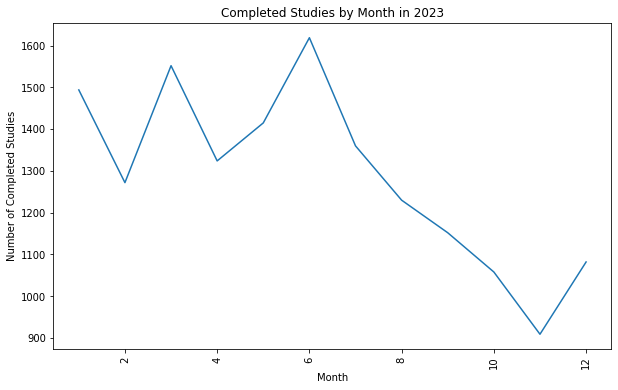

In [0]:
from pyspark.sql.functions import month, year
import matplotlib.pyplot as plt

completed_studies_2023 = cleandf.filter(cleandf["Status"] == "COMPLETED") \
    .filter(year("Completion") == 2023)
completed_studies_2023 = completed_studies_2023.withColumn("Completion_Month", month("Completion"))
monthly_counts = completed_studies_2023.groupBy("Completion_Month").count().orderBy("Completion_Month")

monthly_counts_list = monthly_counts.collect()

months = [row[0] for row in monthly_counts_list]
counts = [row[1] for row in monthly_counts_list]

plt.figure(figsize=(10, 6))
plt.plot(months, counts)
plt.xlabel('Month')
plt.ylabel('Number of Completed Studies')
plt.title('Completed Studies by Month in 2023')
plt.xticks(rotation=90)
plt.show()